In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


You can get the dataset here:
    
https://www.kaggle.com/mlg-ulb/creditcardfraud
    
It's too big for me to upload to github. You'll need a Kaggle account.

In [2]:
data = pd.read_csv('creditcard.csv')

# Un-comment this code if you have a slow computer
# and want a smaller dataset.
# (Should work fine but I can't guarantee it)

# data = data.sample(25000)

In [3]:
data.shape

(284807, 31)

data.describe() isn't all that helpful in this dataset so I won't display it.

In [4]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
# normalize=True gives you percentages rather than counts
data['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

99.8% of our transactions are legitimate, and only 0.2% are fraudulent. HUGE class imbalance.

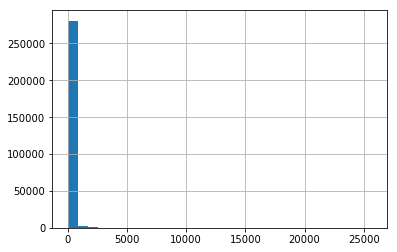

In [6]:
data.Amount.hist(bins=30)

The "tail" is realllllllllly long here, so let's just plot amounts less than $2000.

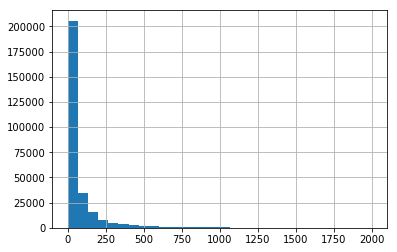

In [7]:
data[data.Amount < 2000].Amount.hist(bins=30)

The  "time" column is **seconds elapsed since the first transaction in the dataset**. The window is only 2 days in total.

I don't think we can perform meaningful machine learning with the feature the way it currently is... but what if we use this to estimate the time of day the transaction took place?

In [8]:
# 3600 seconds in an hour
hours = data.Time/3600
data['hour'] = round(hours % 24, 0)

# The float values screwed up our conversion a bit
# so let's change 24 hours to 0 hours as it should be
data['hour'] = np.where(data.hour == 24, 0.0, data.hour)
# ("Where the hour is 24, set it to 0.0, else keep the original value")

# Delete original time column
del data['Time']

Alright, let's see if this works...

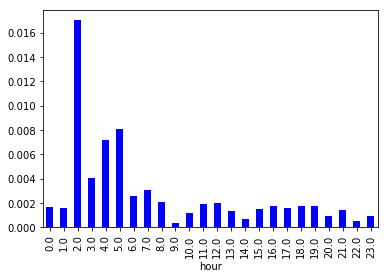

In [9]:
data.groupby('hour')['Class'].mean().plot.bar(color='blue')

Wow! I didn't think it'd work quite this well, but certain hours are much more suspicious than others! Just keep in mind that these don't represent actual hours, because we don't know when the original times are. 2 MIGHT be 2am, but it could also be 6am, 10pm, etc. We don't know.

# Machine learning

In [10]:
x = data.drop('Class', axis=1)
y = data['Class']

In [11]:
from sklearn.model_selection import train_test_split

# Since our dataset is so big, we can get away with only using 10%
# of our data for testing. This assumes you didn't shrink the dataset.
# If you did, increase the test size to 0.2 or so.
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.1)

In [12]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Recall that k-fold is a way of splitting up your training data such that every data point in your set is tested on at least once. Since you want to -- both in theory and in practice -- maximize the size of both your training and testing sets, k-fold is a brilliant solution to the problem!

`StratifiedKFold` is used exclusively for classification problems. You'll get an error if you try using it for regression. It splits up your data such that each "fold" has roughly the same class distribution. So, just like in our original dataframe, each fold will have about 99.8% legitimate and 0.2% fraudulent transations.

StratifiedKFold is especially useful because you might otherwise end up with folds that have NO fraudulent transactions. And then you can't perform machine learning on them. And you'll get an error.

So you should pretty much always use StratifiedKFold when you're dealing with imbalanced classes.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

lr = LogisticRegression()

cvs = cross_val_score(lr, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('LOGISTIC REGRESSION')
print('*******************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

LOGISTIC REGRESSION
*******************
Mean score: 0.9732244531651382
Std dev: 0.008595641399341016


Because the "Amount" column had such a long tail -- what we call a "power-law" distribution, we really should transform it and take the log before performing a logistic regression.

`np.log1p` calculates the log of 1 plus the value. This is useful because the log of zero is undefined and you'll get an error if there are any zeroes in your column.

In [122]:
xtrain_log = xtrain.copy()

xtrain_log['Amount'] = np.log1p(xtrain_log['Amount'])

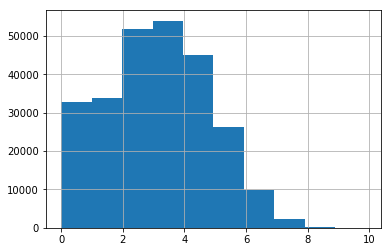

In [123]:
# Check this out -- it's almost normally distributed now!
xtrain_log['Amount'].hist()

In [121]:
cvs = cross_val_score(lr, xtrain_log, ytrain, cv=kf, scoring='roc_auc')

print('LOGISTIC REGRESSION')
print('*******************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

LOGISTIC REGRESSION
*******************
Mean score: 0.9721580531569789
Std dev: 0.008465409545492852


Turns out log-amount doesn't really matter in this model, but it's still a tool I wanted to show you.

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

cvs = cross_val_score(knn, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('K-NEAREST NEIGHBORS')
print('*******************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

K-NEAREST NEIGHBORS
*******************
Mean score: 0.8660442733717343
Std dev: 0.02565677635496694


In [47]:
from sklearn.tree import DecisionTreeClassifier

tr = DecisionTreeClassifier()

cvs = cross_val_score(tr, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('DECISION TREE')
print('*************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

DECISION TREE
*************
Mean score: 0.8784663235805041
Std dev: 0.02389989504820404


# Grid Search

Grid search is the process of testing different settings ("hyperparameters") until it discovers the combination that works best. In real-world machine learning problems, you usually won't have to directly consider things like bias/variance, over-/underfitting, etc. `GridSearchCV` takes care of all of this for you.

Our logistic regression is currently doing the best, but I want to show you how grid search works using a decision tree's hyperparameters.

In [48]:
from sklearn.model_selection import GridSearchCV

# Using 3 splits because it's soooo slow
kf3 = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': [3, 9],
    'min_samples_leaf': [1,5],
    'min_samples_split': [2,10,20],
}

grid = GridSearchCV(tr, param_grid=param_grid, cv=kf3, scoring='roc_auc').fit(xtrain, ytrain)

clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [49]:
cvs = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('GRID SEARCH 1')
print('*************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

GRID SEARCH 1
*************
Mean score: 0.8957454528569088
Std dev: 0.026258263722951983


Always remember that the number of combinations *explodes* as you add more options to your parameter grid. Even under the best of circumstances, a grid search is going to take a couple of minutes to run.

There's no way around this, but I'll remind you of the compromise I settle on. I run successive grid searches and make continuous adjustments until the performance stabilizes.

By doing this, you'll arrive at a "local maximum" -- a machine learning model that's the best out of the dozen(s) you've tested, but not necessarily the best model possible. In fact, it's probably not. But that's a unicorn you'll never find.

In [50]:
from sklearn.model_selection import GridSearchCV

# Using 3 splits because it's soooo slow
kf3 = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': [7, 9, 12],
    'min_samples_leaf': [5, 10,20],
    'min_samples_split': [20, 30, 50],
}

grid = GridSearchCV(tr, param_grid=param_grid, cv=kf3, scoring='roc_auc').fit(xtrain, ytrain)

clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
cvs = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('GRID SEARCH 2')
print('*************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

GRID SEARCH 2
*************
Mean score: 0.921757168979705
Std dev: 0.019072686450269768


In [52]:
from sklearn.model_selection import GridSearchCV

# Using 3 splits because it's soooo slow
kf3 = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': [8, 9, 10],
    'min_samples_leaf': [10],
    'min_samples_split': [50, 100],
}

grid = GridSearchCV(tr, param_grid=param_grid, cv=kf3, scoring='roc_auc').fit(xtrain, ytrain)

clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [53]:
cvs = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('GRID SEARCH 3')
print('*************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

GRID SEARCH 3
*************
Mean score: 0.9304998596570939
Std dev: 0.020899571629115394


In [54]:
from sklearn.model_selection import GridSearchCV

# Using 3 splits because it's soooo slow
kf3 = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': [10,11],
    'min_samples_leaf': [10],
    'min_samples_split': [40, 50, 60],
}

grid = GridSearchCV(tr, param_grid=param_grid, cv=kf3, scoring='roc_auc').fit(xtrain, ytrain)

clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [55]:
cvs = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('GRID SEARCH 4')
print('*************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

GRID SEARCH 4
*************
Mean score: 0.9282307073212612
Std dev: 0.024700063617366246


It looks like we've settled on a good set of hyperparameters. Let's look at why I like ROC-AUC as a metric and perform a final evaluation of our model.

When working on a classification problem, your model can output the **probabilities** of each data point being a certain class. Watch this:

In [56]:
preds = clf.predict_proba(xtrain)

preds

array([[9.99917011e-01, 8.29886393e-05],
       [9.99917011e-01, 8.29886393e-05],
       [9.99917011e-01, 8.29886393e-05],
       ...,
       [9.99917011e-01, 8.29886393e-05],
       [9.99917011e-01, 8.29886393e-05],
       [9.99917011e-01, 8.29886393e-05]])

Each of those rows represents the probabilities across the different classes we have -- in this case "0" for legitimate and "1" for fraudulent (in that order). And, in these situations we're most interested in the **probability of fraud**. So let's change preds to represent the 2nd number in each row:

In [57]:
# All rows, index 1
preds = preds[:, 1]

In [65]:
# And now we have...
pd.Series(preds).value_counts()

0.000083    228947
0.000808     12381
0.001194      8373
0.000823      3644
0.002375      1263
0.000000       775
0.010563       284
1.000000       197
0.224490        49
0.693878        49
0.111111        45
0.100000        40
0.057143        35
0.941176        34
0.821429        28
0.925926        27
0.200000        20
0.421053        19
0.058824        17
0.529412        17
0.800000        15
0.571429        14
0.272727        11
0.181818        11
0.090909        11
0.900000        10
0.300000        10
dtype: int64

The vast majority of our predictions are essentially zero -- which is good, because any given transaction only has a prior probability of 0.2% that it's fraudulent.

So now let's take a look at ROC-AUC and why I like it in conjunction with `pred_proba`.

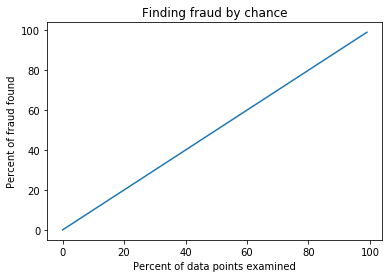

In [110]:
# Don't worry about the code here
# I just wanted to draw this graph!

import matplotlib.pyplot as plt

plt.xlabel("Percent of data points examined")
plt.ylabel("Percent of fraud found")
plt.title('Finding fraud by chance')

df = pd.DataFrame()
df['x'] = np.arange(100)
df['y'] = np.arange(100)


df['x'].plot();

Really examine this and think about what I mean by it.

If you just examined each data point (in random order) and called it fraud, your fraud identification rate would be this straight line. You'd just find them at the rate of chance.

What ROC-AUC is essentially doing, is examining the most likely fraud cases first, and working its way down the list.

Another way to think of this is that with each data point you examine, you're moving right on the graph. Your goal is to move **up** at the same time as rapidly as possible, and you do this by finding fraudulent transactions.

Let me show you a preview of where I'm going with this, and then we'll do it for real.

In [79]:
# Sometimes pandas doesn't properly read a numpy array
# and you get NaNs instead. So I fixed this by casting
# ytrain to a list.
df = pd.DataFrame(list(ytrain), columns=['fraud'])
df['prediction'] = pd.Series(preds)

# Was a transaction fraudulent, and what did our model predict:
df.sort_values('prediction', ascending=False).head(10)

,fraud,prediction
235818,1,1.0
21765,1,1.0
49735,1,1.0
34395,1,1.0
44372,1,1.0
18784,1,1.0
10122,1,1.0
169658,1,1.0
155382,1,1.0
104598,1,1.0


In [81]:
df.sort_values('prediction', ascending=False).tail(10)

,fraud,prediction
114719,0,0.0
131595,0,0.0
168326,0,0.0
37305,0,0.0
47512,0,0.0
104355,0,0.0
47498,0,0.0
213580,0,0.0
70984,0,0.0
221867,0,0.0


You can already see how good our model fit the training data. It doesn't seem to make mistakes when it predicts a 1.0 or a 0.0.

So now let's build our curve.

In [84]:
df = df.sort_values('prediction', ascending=False)

# "Cumulative sum" -- it's keeping a running
# count (or should I say sum) of the fraud column.
df['fraud_count'] = np.cumsum(df['fraud'])

In [86]:
# Normalize our counts to a percent
df['fraud_pct_found'] = df['fraud_count']/df['fraud'].sum()


df

,fraud,prediction,fraud_count,fraud_pct_found
235818,1,1.0,1,0.002268
21765,1,1.0,2,0.004535
49735,1,1.0,3,0.006803
34395,1,1.0,4,0.009070
44372,1,1.0,5,0.011338
18784,1,1.0,6,0.013605
10122,1,1.0,7,0.015873
169658,1,1.0,8,0.018141
155382,1,1.0,9,0.020408
104598,1,1.0,10,0.022676


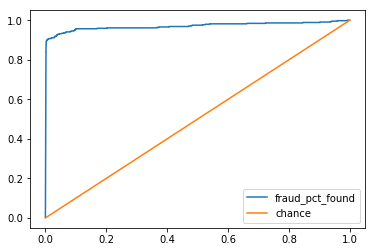

In [101]:
# Double-brackets keeps this as a dataframe, rather than a series
fraud_plot = df[['fraud_pct_found']].copy()

fraud_plot.index = np.arange(len(fraud_plot))/len(fraud_plot)

# Build our straight line for random chance
fraud_plot['chance'] = np.arange(len(fraud_plot))/len(fraud_plot)

fraud_plot.plot()

Area under the curve *represents that area under the curve!* Cool, huh?

Let me show you another reason AUC is such a powerful metric.

Since 99.8% of our transactions are legit, we'd obtain amazing accuracy just by always predicting a zero.

But what would that graph look like?

...

If you said it's essentially $y = 0$, then you're absolutely right. And the AUC score for that would be... zero!

Conversely, if we always predict fraud, then we get that straight line of $y = x$. The AUC score for that is 0.50. So anything above 0.50 is an indication that your model is learning.

And it's only by balancing false positives and true positives that we get rewarded with a high score.

Here are some more rules of thumb for interpreting your AUC score:

- Below 0.50: Worse than random chance. Delete Python immediately.
- 0.50 - 0.60: Not that great, but better than chance at least.
- 0.60 - 0.70: Okay/Good.
- 0.70 - 0.80: Good/Really good.
- 0.80 - 0.90: Excellent.
- 0.90 and above: Too good. Your model is probably leaking data and cheating. Or maybe you found a dataset with fake/synthetic data.

In [124]:
preds_test = clf.predict_proba(xtest)

from sklearn.metrics import roc_auc_score

# Don't forget, you need the 2nd value (index 1) of each pair
preds_test = preds_test[:, 1]

roc_auc_score(ytest, preds_test)

0.9636792810687412

Our score here is above 0.90. I think we really lucked out here and found a problem that lends itself extremely well to machine learning. I can't find any irregularities that would lead to an abnormally high score. So we'll assume we just did a really good job. :)

# TPOT

`pip install tpot`

TPOT is a library that automatically runs grid search for you! It uses a "genetic" algorithm to let the best model "evolve" over successive generations -- pretty much the same thing we did earlier with successive grid searches.

We've already scored our testing data, so consider this section a bonus tutorial. You're not allowed to tune your model after scoring it on test data!

In [126]:
from tpot import TPOTClassifier

# Very modest settings since our dataset is huge
# and this will take a long time.
tpot = TPOTClassifier(population_size=10, generations=2, verbosity=2)

tpot.fit(xtrain, ytrain)

Generation 1 - Current best internal CV score: 0.9994928334211053
Generation 2 - Current best internal CV score: 0.9994928334211053

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.15000000000000002, min_samples_leaf=3, min_samples_split=2, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=2,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=10,
        random_state=None, scoring=None, subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

In [127]:
# You can export/save your model's settings:
tpot.export('fraud_classifier.py')

In [129]:
from sklearn.ensemble import ExtraTreesClassifier

# Look above -- it printed this out
clf_tpot = ExtraTreesClassifier(
    bootstrap=False, criterion="gini",
    max_features=0.15000000000000002, min_samples_leaf=3,
    min_samples_split=2, n_estimators=100
)

In [130]:
cvs = cross_val_score(clf_tpot, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('TPOT CROSS VALIDATION')
print('*********************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

TPOT CROSS VALIDATION
*********************
Mean score: 0.9672888843209002
Std dev: 0.01334377376091794


That's pretty darn good! Funny how our logistic regression with no tuning is still the best model, though. ML can be unpredictable!

One last thing: XGBoost is super powerful but it's a pain in the butt to install. Maybe I'll go over how to do it.

In [13]:
from xgboost import XGBClassifier

In [17]:
from sklearn.model_selection import GridSearchCV

# Using 3 splits because it's soooo slow
kf3 = StratifiedKFold(n_splits=3)
xg = XGBClassifier()

param_grid = {
    'max_depth': [2,3],
    'n_estimators': [200]
}

grid = GridSearchCV(xg, param_grid=param_grid, cv=kf3, scoring='roc_auc').fit(xtrain, ytrain)

clf = grid.best_estimator_

clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [18]:
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='roc_auc')

print('GRID SEARCH XGBOOST')
print('*************')
print('Mean score:', cvs.mean())
print('Std dev:', cvs.std())

GRID SEARCH XGBOOST
*************
Mean score: 0.9821071458680114
Std dev: 0.009300152954796609
